

# <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">EDA/ Classification/Deployment if the text is sarcasmic or not with Bidirectional LSTM/CNN/Logistic Regression</p>

<img src="https://thumbs.dreamstime.com/z/sarcasm-seal-print-scratced-style-blue-vector-rubber-print-sarcasm-title-corroded-texture-text-title-placed-138701372.jpg"  width="1000" height="600">


<p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Table Of Contents</p>   
    
* [1. Importing Modules](#1)
    
* [2. Loading Data](#2)
    
* [3. Data PreProcessing And Visualizations](#3)
      
* [4. Modelling](#4)
    
* [5. Results And Conclusion](#5)
 



<a id="1"></a>
# <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">1. Importing Libraries</p>

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.layers import Conv1D, Flatten,MaxPooling1D
from keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc



<a id="2"></a>
# <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">2. Loading Data</p>

In [34]:
# Importing the csv data files 
sarcasm_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')
sarcasm_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...



<a id="3"></a>
# <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">3. Data PreProcessing And Visualizations</p>

In [3]:
# Data Pre-Processing
# Removing the null comments
sarcasm_df.dropna(subset=['comment'], inplace=True)
sarcasm_df['comment'] = sarcasm_df['comment'].str.lower()
sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('[^\w\s]','')

In [4]:
# Converting the timestamp into DateTime object
sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010773 non-null  int64         
 1   comment         1010773 non-null  object        
 2   author          1010773 non-null  object        
 3   subreddit       1010773 non-null  object        
 4   score           1010773 non-null  int64         
 5   ups             1010773 non-null  int64         
 6   downs           1010773 non-null  int64         
 7   date            1010773 non-null  object        
 8   created_utc     1010773 non-null  datetime64[ns]
 9   parent_comment  1010773 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB



## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Distribution of the classes in the dataset</p>

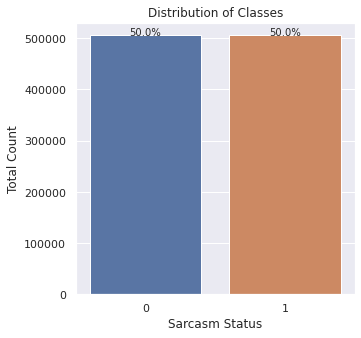

In [5]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= sarcasm_df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

The figure above ensures that the dataset is balanced as the proportion of the sarcastic and non-sarcastic comments are same i.e.- 50%



## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Length of the comments</p>

Lets see if there is any relation between the length of the comment and the comment being sarcastic

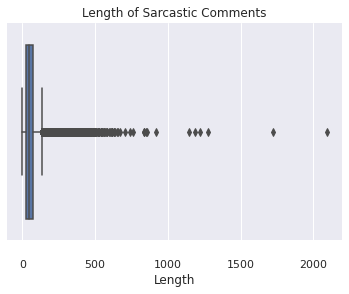

In [6]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

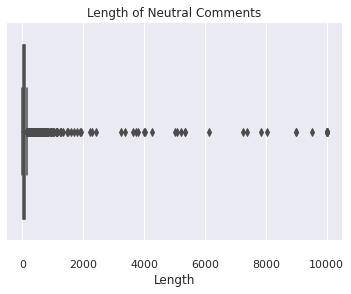

In [7]:
# Distribution of the lenth of Neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 0, 'comment'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

Since the dataset is skewed log transformations are being made

Natural Log Length of Comments for Sarcastic and Non-Sarcastic Comments

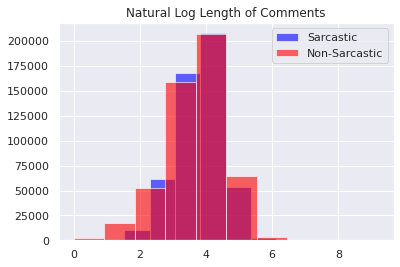

In [8]:
sarcasm_df['log_comment'] = sarcasm_df['comment'].apply(lambda text: np.log1p(len(text)))
sarcasm_df[sarcasm_df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'blue')
sarcasm_df[sarcasm_df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'red')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()




## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Wordcloud of  Sarcastic comments</p>

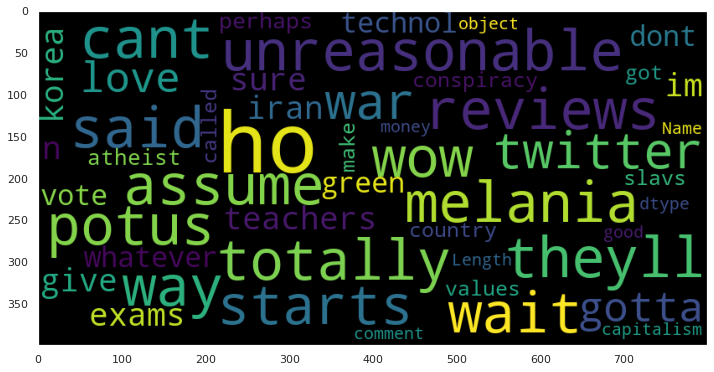

In [9]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);





## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Popularity of the comments according to being sarcastic</p>

With the help of the score of the comments, we can determine whether the sarcastic comments are more popular in Reddit discussions.

In [10]:
# Converting the scores into numpy array
sarcasm_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['score'])
neutral_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 0]['score'])

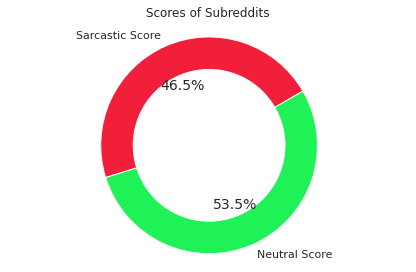

In [11]:
# Displaying the distribution of Marital Status in a Pie chart
labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]
#colors
colors = ['#F21F3B', '#1FF257']
 
plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.tight_layout()
plt.show()

According to the dataset sarcastic comments tend to be less popular due to having lower overall scores.






## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Length of Sarcastic comment compared to the parent comment</p>

Now, lets determine whether the length of the sarcastic comments is more than its parent comment.

In [12]:
sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())/(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len()))

In [13]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])

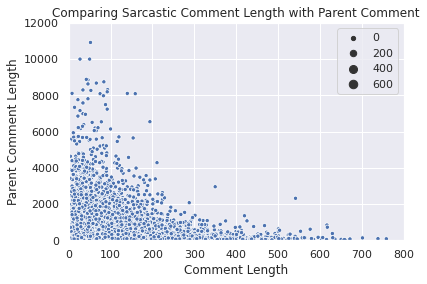

In [14]:
ax = plt.axes()
sns.scatterplot(data=dataset, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")
# control x and y limits
plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

According to the above visual, we can conclude that in most of the cases; the length of the sarcastic comments is longer than its corresponding parent comment.


## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Top Five popular subreddits & Sarcastic comments</p>

In this EDA we will analyse the proportion of sarcastic comments for top 5 Subreddits in the dataset. 

In [15]:
# Getting the top 5 popular subreddits
sarcasm_df['subreddit'].value_counts()[:5]

AskReddit          65674
politics           39493
worldnews          26376
leagueoflegends    21034
pcmasterrace       18987
Name: subreddit, dtype: int64

In [16]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']

In [17]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [18]:
# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[sarcasm_df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

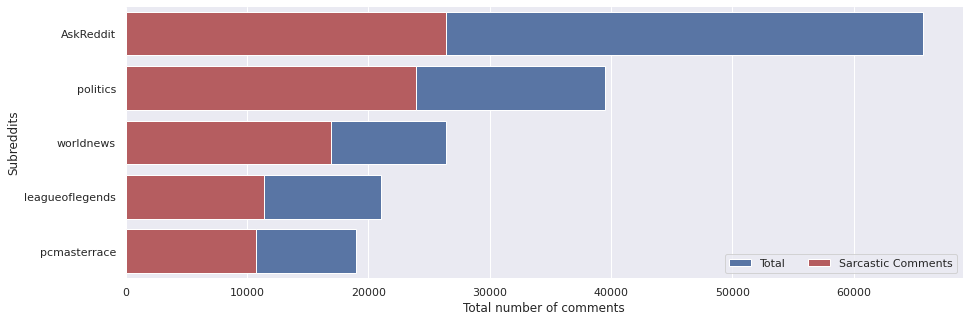

In [19]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)



## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Being sarcastic on a specific day of the week</p>

In this EDA we are tying to figure out wehther the user of Reddit tend to be more sarcastic on a specific day of the week.

In [20]:
# Feature Engineering- Extracting the day of a week
sarcasm_df['created_utc'] = pd.to_datetime(sarcasm_df['created_utc'], format = '%d/%m/%Y %H:%M:%S')
sarcasm_df['Day of Week'] = sarcasm_df['created_utc'].dt.day_name()

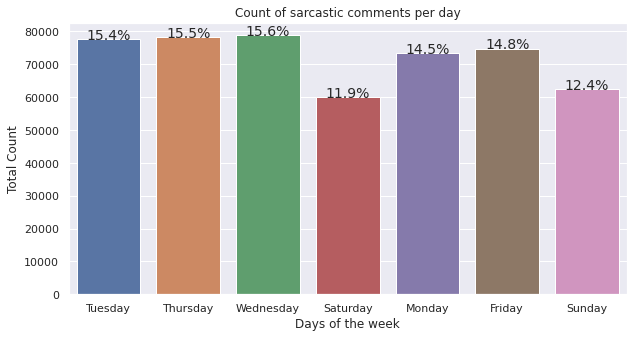

In [21]:
# Visualization of Column- label
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  data= sarcasm_df.loc[sarcasm_df['label']==1])
ax.set(title = "Count of sarcastic comments per day", xlabel="Days of the week", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center") 
plt.show()

According to the visual above we can see that the the count of the sarcastic comments decreases during the weekends. One of the reason for this issue could be due to the reduced number of traffic in Reddit during the weekends 


<a id="4"></a>
# <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">4. Modelling</p>



## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Using Logistic Regression</p>

In [22]:

logit = LogisticRegression(random_state= 42)

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(sarcasm_df['comment'])
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, sarcasm_df['label'], random_state=42)



logit.fit(x_train, y_train)



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

In [23]:
predicted_class=logit.predict(x_test)
predicted_class_train=logit.predict(x_train)
test_probs = logit.predict_proba(x_test)
test_probs = test_probs[:, 1]
yhat = logit.predict(x_test)
train_accuracy = accuracy_score(y_train,predicted_class_train)
test_accuracy = accuracy_score(y_test,predicted_class)
print("Train accuracy score: ", train_accuracy)
print("Test accuracy score: ",test_accuracy )
print()

Train accuracy score:  0.72232445431149
Test accuracy score:  0.6935661313683744





## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Using a Bidirectional LSTM</p>

In [25]:
sarcasm_df.reset_index(drop = True, inplace = True)
corpus = [sarcasm_df['comment'][i] for i in range( len(sarcasm_df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length = 20

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40

X_final=np.array(embedded_docs)
y_final=np.array(sarcasm_df['label'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [26]:
lstm_model=Sequential()
lstm_model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(100)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


> Using a bidirectional LSTM, because it can help the model detect the context of the statement in a better way which can be missed out otherwise if using an LSTM.

In [28]:

lstm_model.fit(X_train_lstm,y_train_lstm,validation_data=(X_test_lstm,y_test_lstm),epochs=10,batch_size=64)


Epoch 1/10
10582/10582 [==============================] - 136s 13ms/step - loss: 0.5438 - accuracy: 0.7198 - val_loss: 0.5643 - val_accuracy: 0.7039
Epoch 2/10
10582/10582 [==============================] - 136s 13ms/step - loss: 0.5386 - accuracy: 0.7234 - val_loss: 0.5642 - val_accuracy: 0.7048
Epoch 3/10
10582/10582 [==============================] - 137s 13ms/step - loss: 0.5341 - accuracy: 0.7263 - val_loss: 0.5661 - val_accuracy: 0.7050
Epoch 4/10
10582/10582 [==============================] - 136s 13ms/step - loss: 0.5292 - accuracy: 0.7301 - val_loss: 0.5647 - val_accuracy: 0.7051
Epoch 5/10
10582/10582 [==============================] - 138s 13ms/step - loss: 0.5252 - accuracy: 0.7332 - val_loss: 0.5651 - val_accuracy: 0.7057
Epoch 6/10
10582/10582 [==============================] - 137s 13ms/step - loss: 0.5220 - accuracy: 0.7359 - val_loss: 0.5678 - val_accuracy: 0.7054
Epoch 7/10
10582/10582 [==============================] - 138s 13ms/step - loss: 0.5191 - accuracy: 0.7374

> The model here certainly is not overfitting; however, I feel the accuracies can be improved. Working on tuning the model in next version.

In [29]:
y_test_pred=lstm_model.predict_classes(X_test_lstm)
y_train_pred=lstm_model.predict_classes(X_train_lstm)
test_acc_lstm = accuracy_score(y_test_lstm,y_test_pred)
train_acc_lstm = accuracy_score(y_train_lstm,y_train_pred)


print('Train accuracy of lstm: ',train_acc_lstm)

print('Test accuracy of lstm: ', test_acc_lstm)

Train accuracy of lstm:  0.7703513054161369
Test accuracy of lstm:  0.7037828730408088




## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Using a CNN</p>

In [30]:

vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [31]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df['comment'], sarcasm_df['label'], test_size=0.33, random_state=42)

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


In [32]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn_model.add(Dropout(.5))
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation ='relu'))
cnn_model.add(Dropout(.5))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


cnn_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


Epoch 1/10
10582/10582 [==============================] - 148s 14ms/step - loss: 0.6174 - accuracy: 0.6543 - val_loss: 0.6018 - val_accuracy: 0.6685
Epoch 2/10
10582/10582 [==============================] - 146s 14ms/step - loss: 0.6057 - accuracy: 0.6669 - val_loss: 0.5986 - val_accuracy: 0.6731
Epoch 3/10
10582/10582 [==============================] - 146s 14ms/step - loss: 0.6027 - accuracy: 0.6697 - val_loss: 0.5976 - val_accuracy: 0.6735
Epoch 4/10
10582/10582 [==============================] - 145s 14ms/step - loss: 0.6012 - accuracy: 0.6709 - val_loss: 0.5958 - val_accuracy: 0.6742
Epoch 5/10
10582/10582 [==============================] - 146s 14ms/step - loss: 0.6001 - accuracy: 0.6723 - val_loss: 0.5964 - val_accuracy: 0.6747
Epoch 6/10
10582/10582 [==============================] - 146s 14ms/step - loss: 0.5990 - accuracy: 0.6733 - val_loss: 0.5948 - val_accuracy: 0.6761
Epoch 7/10
10582/10582 [==============================] - 146s 14ms/step - loss: 0.5982 - accuracy: 0.6739

> Using a CNN here because each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating the outputs,we can detect patterns of multiples size.

## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Preparing the model for deployment using Logistic Regression</p>

> **I am using logitic regression model for deployment. Also using the entire dataset to learn when deploying the model to expand the model's learning.**

In [33]:
logit = LogisticRegression(random_state= 42)

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(sarcasm_df['comment'])

logit.fit(X_tf_idf,  sarcasm_df['label'])

pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(logit, open('logit.pkl', 'wb'))

# Saving the model and the tf idf object so as to transform the new data which is to be predicted if that is sarcastic or not
logit = pickle.load(open('logit.pkl','rb'))
vectorizer=pickle.load(open('vectorizer.pkl','rb'))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



<a id="5"></a>
# <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">5. Results & Conclusions</p>

> **Bidirectional LSTM is performing better here, although not by a great margin..**

> **Created the app using Flask.**

> **Deployed the model on heroku. Checkout the app, if you want to go through the code, checkout my github.**

> **App link: https://check-if-its-sarcastic-or-not.herokuapp.com/**